# Attendance

[The link to SEAts](https://gold.seats.cloud/angular/#/lectures)

[Evaluations!](http://www.doc.gold.ac.uk/evaluation) 🙏

In [1]:
import os
import sys
import pathlib

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

tf.get_logger().setLevel('WARNING') # https://stackoverflow.com/a/38873777

---

# 12 Generative deep learning

- ## Text generation
- ## DeepDream
- ## Neural style transfer
- ## Variational autoencoders
- ## Generative adversarial networks


---

## 12.1 Text generation

“Generating sequential data is the closest computers get to dreaming.”

Alex Graves

NNs can generate new sequence data:

- text (all kinds, including summaries, dialogue);
- music (samples, notes);
- speech synthesis;
- handwriting or brushstrokes recorded on an iPad;
- even images, if considered like a sequence of pixels!

## 12.1.1 A brief history of generative deep learning for sequence generation

- 2002: [Eck & Schmidhuber, "A first look at music composition using LSTM recurrent neural networks"](https://people.idsia.ch/~juergen/blues/IDSIA-07-02.pdf);
- 2013: [Alex Graves, "Generating Sequences With Recurrent Neural Networks"](https://arxiv.org/abs/1308.0850);
- 2015: Google's DeepDream produced psychedelic images: ["Inceptionism: Going Deeper into Neural Networks"](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html);
- 2016: [Sunspring](https://www.youtube.com/watch?v=LY7x2Ihqjmc), an experimental film with an LSTM generated script;
- 2016: DeepMind's [WaveNet: A generative model for raw audio](https://www.deepmind.com/blog/wavenet-a-generative-model-for-raw-audio);
- 2016: Google's [Smart Reply](https://developers.google.com/ml-kit/language/smart-reply) – automatic generation of short replies to emails and text messages.

- 2019: GPT-2 (1.5 bn): ["Better Language Models and Their Implications"](https://openai.com/blog/better-language-models/);
- 2020: GPT-3 (175 bn): ["Language Models are Few-Shot Learners"](https://arxiv.org/abs/2005.14165), and the [API](https://openai.com/api/);
- 2020: [Jukebox](https://openai.com/blog/jukebox/), "a neural net that generates music, including rudimentary singing, as raw audio";
- 2021-2: OpenAI's [WebGPT](https://openai.com/blog/webgpt/), [InstructGPT](https://openai.com/blog/instruction-following/) and [ChatGPT](https://openai.com/blog/chatgpt/).
- 2023: [GPT-4](https://openai.com/research/gpt-4), [Llama 1,2,3,...](https://ai.meta.com/llama/), many more!

Deep learning algorithms can learn a statistical **latent space**: a structured compression or *distillation* of the data.

That space, like word embeddings, displays remarkable properties, and *can be explored*!

**Sampling from the latent space** 'creates' new artworks similar to the training data.

Chollet claims that this removes the barriers of craft and skills, to allow for more straightforward expression.

In my own experience, I find that it **shifts** the craft and skills needed elsewhere, rather than removing those.

*"What I cannot create, I don't understand."*

Richard P. Feynman

Perhaps another key motivation for Deep Learning researchers and engineers to pursue the generative route.

### The replacement debate

Chollet stands firmly on one end, saying AI will lead to *augmented intelligence*, rather than anything autonomous.

Others claim that AGI is already here, and that it will surpass humanity in a blink of an eye.

#### Question

Players of chess, Go and StarCraft/Dota 2 now live with the idea that there is a machine somewhere that is likely **always** to be better than them. (Apparently chess is more popular than ever!) This certainly does not seem to have happened for the arts, but what if it did? What would be the consequences for art and artists?

---

## 12.1.2 How do you generate sequence data?

Train a network to predict the next token(s) in a sequence using the previous tokens as input.

Source for tokens:  words, characters, samples, pixels, byte.

Any *text-based* model is known as a **language model**.

A language model captures the *latent space* of language i.e. its **statistical structure**.

### Auto-regressive generation

<!-- ![Chollet, text generation](images/chollet.auto-regressive.p.367.png) -->
<img src="https://github.com/jchwenger/AI/blob/main/8-generative-deep-learning/images/chollet.auto-regressive.p.367.png?raw=true">

<small>DLWP, p.368</small>

### Text generation workflow

1. Train model;
2. Present an initial *conditioning* text string (aka **prompt** or **context**);
3. Model predicts the **probability distribution** for the next token;
4. Sample from that distribution;
4. Add the generated text to the input text;
5. Go back to step 3.

---

## 12.1.3 The importance of the sampling strategy

The **vanilla** way would be just to sample from the softmax output of the model (a probability distribution over the vocab).

This is already smarter than **uniform sampling**, where each token has the same probability (maximum randomness)!

However, we can actually vary the softmax itself (the shape of the probability), to **increase** or **decrease** the level of randomness.

These *intermediate levels of randomness* are controlled by the **softmax temperature** – a fundamental tool for more interesting, creative outputs.

#### Greedy sampling

Always select the **most probable** step. This is called greedy because it is *exactly* the problem you face in real life: pick the best option **now** (= highest reward in the next step) vs have a more long-term strategy (which brings more payoffs in nearly every case).

#### Softmax temperature

Remember, the softmax function is:

$$
\bbox[5px,border:2px solid red]
{
\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_i e^{x_i}}
}
$$

$x_i$: logits (scores) for each token in our vocabulary.


It makes all numbers positive and normalises them (all lie between 0 and one and sum to 1) → they are turned into a **probability distribution**.

The parameterised softmax distribution adds a number $T$ like so:

$$
\bbox[5px,border:2px solid red]
{
\text{softmax}(x_i) = \frac{e^{\frac{x_i}{T}}}{\sum_i e^{\frac{x_i}{T}}}
}
$$

##### Usual values for $T$

Depends on the model!

Around 0.9 (most of the time above 0.7, rarely above 1. unless you yearn for delirium!)

##### Implementation

##### Reweighting a probability distribution to a different temperature

Note that here we use the `log` to (half-)revert the effect of the softmax that the model operates already on its final logits.  In other architectures, the model outputs pre-softmax logits, so you do not need that step and directly divide by the temperature.

In [3]:
def reweight_distribution(original_distribution, temperature=0.5):
    """
    1.a LOG: because `original_distribution` has been softmaxed! (Numerical stability)
      b divide by TEMPERATURE: our reweighting
    2. SOFTMAX: a. exponentiate
                b. divide by the total

    Notes:
        - In many implementations, the log isn't there because the model returns
          logits (before softmax)
        - the last two lines could also be written: `tf.nn.softmax(distribution)`!
    """
    distribution = np.log(original_distribution) / temperature # 1.a + b
    distribution = np.exp(distribution)                        # 2.a
    return distribution / np.sum(distribution)                 # 2.b


#### Temperature: limit cases

1. $T \rightarrow 0$:  
    $\frac{x_i}{T} \rightarrow \infty$ so $e^{\frac{x_i}{T}} \rightarrow \infty$, so the highest probability dominates and the $softmax(x_i)$ becomes just $max(x_i)$: the maximum probability dominates – also known as **greedy sampling**;    
    *If the temperature is too low, the model will tend to repeat itself!* (more 'conservative', less creative)...  
    
    
    
2. $T \rightarrow \infty$:  
    $\frac{x_i}{T} \rightarrow 0$ so $e^{\frac{x_i}{T}} \rightarrow 1$ so $q_i \rightarrow \frac{1}{M}$ where $M$ is the number of softmax outputs – a **uniform distribution** (our well-known **random guess**);  
    *If the temperature is too high, the model will tend to 'derail' and stop making sense!*  
    (The formalisation of the link between creativity and madness?) Σ(▼□▼メ)...
    

##### Plotting the effect of softmax temperature

In [4]:
def plot_softmax_temperature():
    nums = tf.random.uniform(shape=(10,))                           # ten random numbers
    nums = tf.math.log(nums)                                        # take the log (optional)
    probs = tf.nn.softmax(nums)                                     # turned into probabilities

    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(16,12))

    ax1.bar([str(x) for x in range(nums.shape[0])], nums)           # our ten numbers
    ax1.set_title("Log of ten random numbers")
    ax1.set_ylabel("Original range")

    ax2.bar([str(x) for x in range(probs.shape[0])], probs)         # the probabilities
    ax2.set_title("Turned into probabilities")
    ax2.set_ylabel("From zero to one")
    ax2.set_ylim([0,1])

    temp = 0.1                                                      # LOW temperature → very unequal/spiked results
    weighted_nums = nums / temp                                     # reweighting
    probs = tf.nn.softmax(weighted_nums)                            # turned into probabilities

    ax3.bar([str(x) for x in range(probs.shape[0])], weighted_nums) # the probabilities
    ax3.set_title(f"Reweigted by temperature {temp}")
    ax3.set_ylabel("Increased range")

    ax4.bar([str(x) for x in range(probs.shape[0])], probs)         # the probabilities
    ax4.set_title("The distribution is more spiked: likelier tokens will almost always get picked")
    ax4.set_ylabel("From zero to one")
    ax4.set_ylim([0,1])

    temp = 10                                                       # HIGH temperature → very equal/flat results
    weighted_nums = nums / temp                                     # reweighting
    probs = tf.nn.softmax(weighted_nums)                            # turned into probabilities

    ax5.bar([str(x) for x in range(probs.shape[0])], weighted_nums) # the probabilities
    ax5.set_title(f"Reweigted by temperature {temp}")
    ax5.set_ylabel("reduced range")

    ax6.bar([str(x) for x in range(probs.shape[0])], probs)         # the probabilities
    ax6.set_title("The distribution is more flat: less likely tokens will be picked alongside likelier ones")
    ax6.set_ylabel("From zero to one")
    ax6.set_ylim([0,1])

    plt.show()

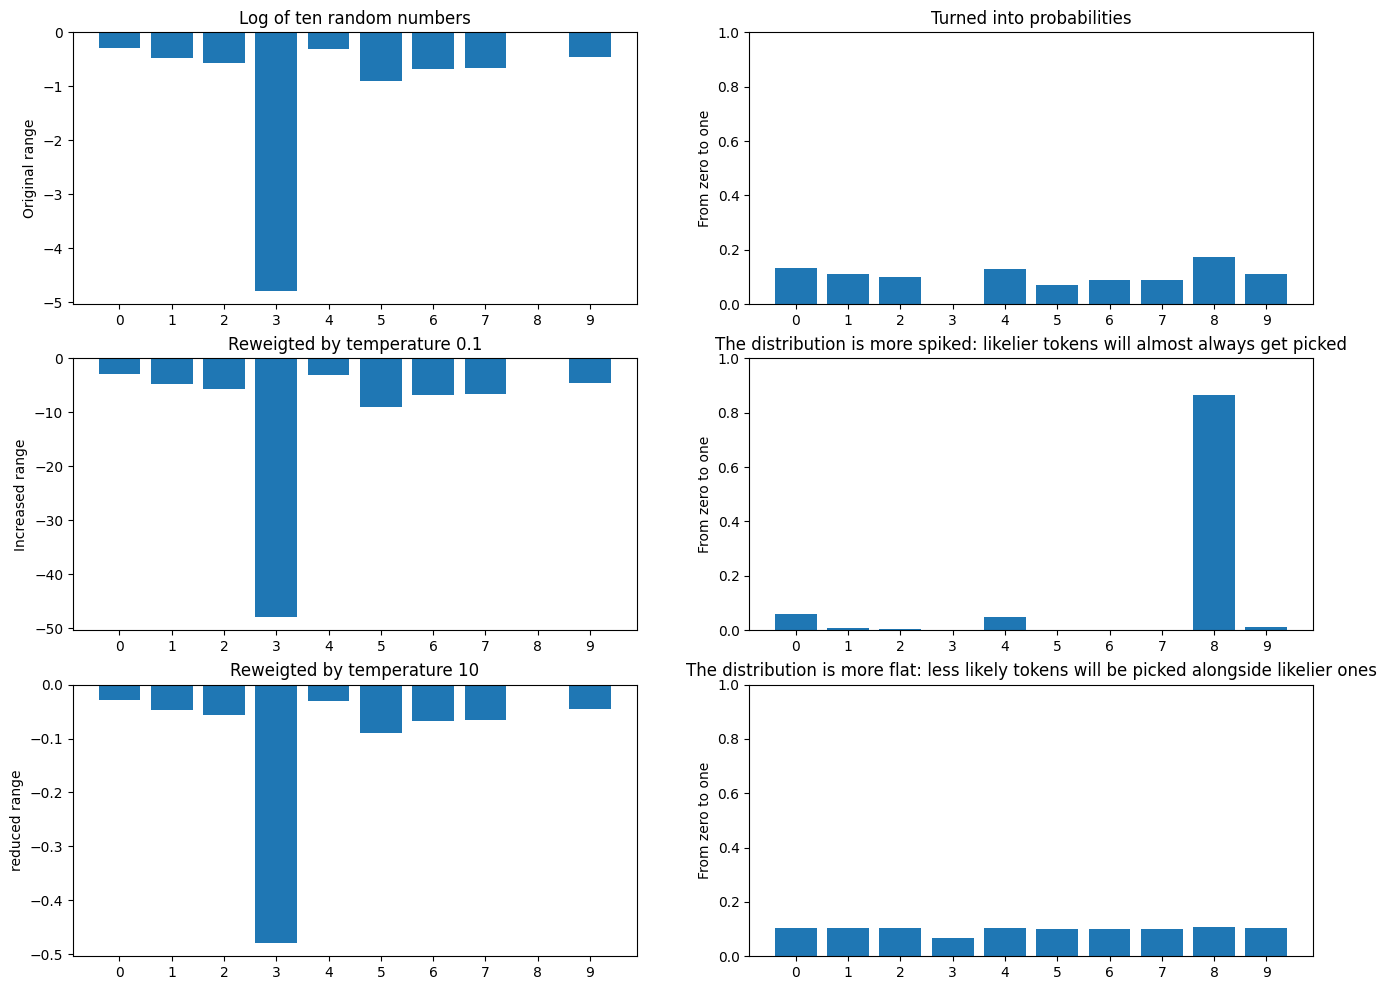

In [5]:
plot_softmax_temperature()

#### More Sampling

Sampling is usually combined with more techniques (it's an active area of research, as usual)

- **Beam search**: generate several branches and iteratively select only the n best ones
- **Top k sampling** (in the [GPT-2 paper](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)): sample among the most k probable tokens, reapply softmax, sample from them only
- [**Top p (nucleus) sampling**](https://arxiv.org/abs/1904.09751): sample among the most probable token which, combined, amount to a probability of p.

See [Patrick von Platen, "How to generate text: using different decoding methods for language generation with Transformers"](https://huggingface.co/blog/how-to-generate).

**Beam Search**: keep the `n_beams` most likely next steps at each step, and regenerate `n_beams` only from those, dropping the less likely branches. As you can see, in the case below, greedy search would not have found the .9, since it wouldn't have selected the .4 path in the first round.

<!-- ![beam search](images/beam_search.png) -->

![beam search](https://github.com/jchwenger/AI/blob/main/8-generative-deep-learning/images/beam_search.png?raw=true)

<small>Source [Patrick von Platen, "How to generate text: using different decoding methods for language generation with Transformers"](https://huggingface.co/blog/how-to-generate)</small>


**Top K**: now matter how many tokens are likely or not, we sample from the same amount.

<!-- ![top k sampling](images/top_k_sampling.png) -->

![top k sampling](https://github.com/jchwenger/AI/blob/main/8-generative-deep-learning/images/top_k_sampling.png?raw=true)
<small>Source [Patrick von Platen, "How to generate text: using different decoding methods for language generation with Transformers"](https://huggingface.co/blog/how-to-generate)</small>

**Top p**: if only a few next tokens are likely, we sample from those.

<!-- ![top p sampling](images/top_p_sampling.png) -->

![top p sampling](https://github.com/jchwenger/AI/blob/main/8-generative-deep-learning/images/top_p_sampling.png?raw=true)

<small>Source [Patrick von Platen, "How to generate text: using different decoding methods for language generation with Transformers"](https://huggingface.co/blog/how-to-generate)</small>

To go even further:

- [min p sampling](https://arxiv.org/abs/2407.01082) ([video](https://www.youtube.com/watch?v=LTf_SJOQH4s)): take the top probability, multiply it by a value (e.g. `0.2`, 20% of that), and use the result as a threshold (any token with less probability than that is discarded)
- [top a sampling](https://github.com/BlinkDL/RWKV-LM/tree/4cb363e5aa31978d801a47bc89d28e927ab6912e?tab=readme-ov-file#the-top-a-sampling-method): same idea as *min p*, except the threshold is computed using $\alpha * \text{top-prob}^\beta$, with $\text{top-prob}$ being the top probability among our tokens, $\alpha\ (= 0.2)$ and $\beta\ (=2)$ as hyperparameters
- [locally typical sampling](https://arxiv.org/abs/2202.00666) ([video](https://www.youtube.com/watch?v=_EDr3ryrT_Y&pp=ygUYdHlwaWNhbCBzYW1wbGluZyBraWxjaGVy) & [interview](https://www.youtube.com/watch?v=AvHLJqtmQkE)): sample only from tokens with an expected information content close to the conditional entropy of the model

---

## 12.1.4 Implementing text generation with Keras

#### Dataset loading & processing

In [6]:
DATASET_DIR = pathlib.Path("text-generation")
if not DATASET_DIR.is_dir():
    DATASET_DIR.mkdir(exist_ok=True)

TEXT_DIR = pathlib.Path(DATASET_DIR / "dataset")
if not TEXT_DIR.is_dir():
    TEXT_DIR.mkdir(exist_ok=True)

In [7]:
PATH_TO_FILE = tf.keras.utils.get_file(
    'min-shakespeare.txt',
    'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt',
    cache_dir=DATASET_DIR,
    cache_subdir=TEXT_DIR.name
)

# Read, then decode for py2 compat.
with open(PATH_TO_FILE, 'rb') as i:
    text = i.read().decode(encoding='utf-8')

# length of text is the number of characters in it
print()
print(f'Length of text: {len(text):,} characters')

print()
print(text[:250])

1115394/1115394 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step

Length of text: 1,115,394 characters

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [8]:
text_vectorization = tf.keras.layers.TextVectorization( # note that we don't limit our vocab size here (no need)!
    standardize=None,
    split="character",
    output_mode="int",
)

text_vectorization.adapt([text])

TOKEN_INDEX = dict(enumerate(text_vectorization.get_vocabulary()))
VOCAB_SIZE = len(text_vectorization.get_vocabulary())   # retrieve the vocab size afterwards

In [9]:
lm_dataset_raw = tf.data.Dataset.from_tensor_slices([text])

for t in lm_dataset_raw:
    print(t.numpy()[:250])

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n'


In [10]:
lm_dataset_tok = lm_dataset_raw.map(text_vectorization)

for t in lm_dataset_tok:
    print(t)
    DATASET_LENGTH = t.shape[0]

tf.Tensor([51 11  9 ... 22 27 12], shape=(1115394,), dtype=int64)


In [11]:
# Flatten the dataset of one long tensor into a dataset of individual tokens (ChatGPT 4 12/23)
lm_dataset_flat = lm_dataset_tok.flat_map(
    lambda x: tf.data.Dataset.from_tensor_slices(x)
)
for t in lm_dataset_flat.take(2):
    print(t)

tf.Tensor(51, shape=(), dtype=int64)
tf.Tensor(11, shape=(), dtype=int64)


In [12]:
SEQUENCE_LENGTH = 100

lm_dataset_seqs = lm_dataset_flat.batch(
    SEQUENCE_LENGTH + 1,
    drop_remainder=True
)

for t in lm_dataset_seqs.take(1):
    print(t)

tf.Tensor(
[51 11  9  8  4  2 39 11  4 11 59  3 10 26 12 45  3 20  5  9  3  2 19  3
  2 25  9  5 21  3  3 14  2  6 10 17  2 20 15  9  4  7  3  9 18  2  7  3
  6  9  2 16  3  2  8 25  3  6 30 27 12 12 28 13 13 26 12 37 25  3  6 30
 18  2  8 25  3  6 30 27 12 12 51 11  9  8  4  2 39 11  4 11 59  3 10 26
 12 52  5 15  2], shape=(101,), dtype=int64)


In [13]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

lm_dataset_batched = (
    lm_dataset_seqs
        .repeat()
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE, drop_remainder=True)
        .prefetch(tf.data.experimental.AUTOTUNE)
)

for t in lm_dataset_batched.take(1):
    print(t.shape)

(64, 101)


In [14]:
def prepare_lm_dataset(tokens_batch):
    x = tokens_batch[:, :-1]  # [a b c d e f g] the model predicts top to bottom,
    y = tokens_batch[:, 1:]   # [b c d e f g h] a → b, a b → c, a b c → d, ..., in one go!
    return x, y

lm_dataset = lm_dataset_batched.map(prepare_lm_dataset, num_parallel_calls=4)

#### Sequence-to-sequence modelling

<!-- ![Chollet seq2seq learning](images/chollet.seq2seq-learning.p.372.png) -->

<img src="https://github.com/jchwenger/AI/blob/main/8-generative-deep-learning/images/chollet.seq2seq-learning.p.372.png?raw=true">

<small>DLWP, p.372</small>

#### Positional Embeddings

In [15]:
@tf.keras.utils.register_keras_serializable("positional_embedding")
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    # new in Keras 3, see: https://keras.io/guides/making_new_layers_and_models_via_subclassing/#best-practice-deferring-weight-creation-until-the-shape-of-the-inputs-is-known
    # See also here: https://github.com/keras-team/keras-nlp/blob/4601d88a61a5d3d15279865769af5155804dd785/keras_nlp/src/layers/modeling/token_and_position_embedding.py#L115
    def build(self, input_shape):
        # token embeddings: semantic information
        self.token_embeddings =tf.keras.layers.Embedding(
            input_dim=self.input_dim, output_dim=self.output_dim
        )
        # position embeddings: syntactic (spatial/temporal) information
        self.position_embeddings =tf.keras.layers.Embedding(
            input_dim=self.sequence_length, output_dim=self.output_dim
        )

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        embedded_tokens = self.token_embeddings(inputs)
        positions = tf.range(start=0, limit=length, delta=1) # delta: step size
        embedded_positions = self.position_embeddings(positions)
        # both embeddings are simply added together!
        return embedded_tokens + embedded_positions

    # copied from the source here: https://github.com/keras-team/keras-nlp/blob/4601d88a61a5d3d15279865769af5155804dd785/keras_nlp/src/layers/modeling/token_and_position_embedding.py#L146
    def compute_mask(self, inputs, mask=None):
        return self.token_embeddings.compute_mask(inputs, mask=mask)

    def get_config(self): # retrieve config as a dict
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config


##### Note: the attention mask

In [16]:
def get_causal_attention_mask(inputs):
    print("Inputs:")
    print(inputs)
    print()
    input_shape = tf.shape(inputs)
    batch_size, sequence_length = input_shape[0], input_shape[1]
    i = tf.range(sequence_length)[:, tf.newaxis]
    j = tf.range(sequence_length)
    print(f"i:\n{i}")
    print()
    print(f"j:\n{j}")
    print()
    mask = tf.cast(i >= j, dtype="int32")
    print("Is i >= j? Boolean cast to ints. (Note the broadcasting)")
    print()
    print(mask)
    print()
    mask = tf.reshape(mask, (1, input_shape[1], input_shape[1])) # adding a batch dimension
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1),
         tf.constant([1, 1], dtype=tf.int32)], axis=0)
    print("We want mask to have the same dims as input, using `tf.tile`.")
    print("Creating the right multiplier for it:")
    print()
    print(mult)
    print()
    tile = tf.tile(mask, mult)
    print("Final mask with batch dimensions:")
    print()
    print(tile)
    return tile

mask = get_causal_attention_mask(tf.random.uniform(shape=(2,10), maxval=50, dtype=tf.int32))

Inputs:
tf.Tensor(
[[36 27 28 20 43 40 34 18 23  6]
 [26 28 16 26 23  5  4 44 29 33]], shape=(2, 10), dtype=int32)

i:
[[0]
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [8]
 [9]]

j:
[0 1 2 3 4 5 6 7 8 9]

Is i >= j? Boolean cast to ints. (Note the broadcasting)

tf.Tensor(
[[1 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 1 0 0 0 0]
 [1 1 1 1 1 1 1 0 0 0]
 [1 1 1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1]], shape=(10, 10), dtype=int32)

We want mask to have the same dims as input, using `tf.tile`.
Creating the right multiplier for it:

tf.Tensor([2 1 1], shape=(3,), dtype=int32)

Final mask with batch dimensions:

tf.Tensor(
[[[1 0 0 0 0 0 0 0 0 0]
  [1 1 0 0 0 0 0 0 0 0]
  [1 1 1 0 0 0 0 0 0 0]
  [1 1 1 1 0 0 0 0 0 0]
  [1 1 1 1 1 0 0 0 0 0]
  [1 1 1 1 1 1 0 0 0 0]
  [1 1 1 1 1 1 1 0 0 0]
  [1 1 1 1 1 1 1 1 0 0]
  [1 1 1 1 1 1 1 1 1 0]
  [1 1 1 1 1 1 1 1 1 1]]

 [[1 0 0 0 0 0 0 0 0 0]
  [1 1 0 0 0 0

#### The Transformer Decoder

In [17]:
@tf.keras.utils.register_keras_serializable("transformer_decoder")
class TransformerDecoder(tf.keras.layers.Layer):

    # simplified class: we don't need two attention layers as we don't have data
    # flowing from an encoder!

    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim                              # parameters
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.supports_masking = True                            # MASK: enforcing causality

    # new in Keras 3, see: https://keras.io/guides/making_new_layers_and_models_via_subclassing/#best-practice-deferring-weight-creation-until-the-shape-of-the-inputs-is-known
    def build(self, input_shape):
        self.attention_1 = tf.keras.layers.MultiHeadAttention(  # multi-head attention
            num_heads=self.num_heads, key_dim=self.embed_dim
        )
        self.dense_proj = tf.keras.Sequential(                  # dense layer on top: like a nonlinearity
            [tf.keras.layers.Dense(self.dense_dim, activation="relu"),
             tf.keras.layers.Dense(self.embed_dim),
             tf.keras.layers.Dropout(0.1)]
        )
        self.layernorm_1 = tf.keras.layers.LayerNormalization() # layer norm
        self.layernorm_2 = tf.keras.layers.LayerNormalization()

    # retrieve config as a dict (necessary for custom Keras layers)
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, mask=None):

        # prepare the causal mask
        causal_mask = self.get_causal_attention_mask(inputs)

        # REGULAR MASKED ATTENTION
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask) # apply the causal mask

        # residual / layer norm
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)

        # dense net (nonlinearity) / layer norm
        proj_output = self.layernorm_2(self.dense_proj(attention_output_1))

        # residual
        return attention_output_1 + proj_output

#### A simple Transformer-based language model

In [18]:
EMBED_DIM = 256
LATENT_DIM = 2048
NUM_HEADS = 2
NUM_LAYERS = 5

LEARNING_RATE = 0.001
print(f"learning rate: {LEARNING_RATE}")

def build_model(embed_dim, latent_dim, num_heads, num_layers):
    inputs = tf.keras.Input(shape=(None,), dtype="int64")
    x = PositionalEmbedding(SEQUENCE_LENGTH, VOCAB_SIZE, embed_dim)(inputs)
    for _ in range(num_layers):
        x = TransformerDecoder(embed_dim, latent_dim, num_heads)(inputs=x) # no encoder input!
    outputs =tf.keras.layers.Dense(VOCAB_SIZE, activation="softmax")(x)    # probability distribution over the vocab
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.RMSprop(LEARNING_RATE),
    )
    return model

model = build_model(EMBED_DIM, LATENT_DIM, NUM_HEADS, NUM_LAYERS)

learning rate: 0.001


In [19]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ positional_embedding                 │ (None, None, 256)           │          42,752 │
│ (PositionalEmbedding)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_decoder                  │ (None, None, 256)           │       1,577,984 │
│ (TransformerDecoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_decoder_1                │ (None, None, 256)           │       1,577,984 │
│ (TransformerDecoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_decoder_2                │ (None, None, 256)           │       1,577,984 │
│ (TransformerDecoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_decoder_3                │ (None, None, 256)           │       1,577,984 │
│ (TransformerDecoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_decoder_4                │ (None, None, 256)           │       1,577,984 │
│ (TransformerDecoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, None, 67)            │          17,219 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,949,891 (30.33 MB)

 Trainable params: 7,949,891 (30.33 MB)

 Non-trainable params: 0 (0.00 B)

---

## 12.1.5 A text-generation callback with variable-temperature sampling

In [20]:
def sample_next(predictions, temperature=1.0):
    predictions = np.asarray(predictions).astype("float64")
    predictions = np.log(predictions) / temperature                 # temperature reweighting
    exp_preds = np.exp(predictions)                                 # these two lines are actually
    predictions = exp_preds / np.sum(exp_preds)                     # a softmax
    probas = np.random.multinomial(1, predictions, 1)               # sampling using our probabilities
    return np.argmax(probas)

class TextGenerator(tf.keras.callbacks.Callback):
    def __init__(self,
                 prompt,                                            # initial context
                 generate_length,                                   # how many words to generate
                 seq_length,
                 temperatures=(1.,),                                # a range of different temperatures
                 print_every=50):
        self.prompt = prompt
        self.generate_length = generate_length
        self.seq_length = seq_length
        self.temperatures = temperatures
        self.print_every = print_every

    def on_epoch_end(self, epoch, logs=None):
        if epoch == 0 or (epoch + 1) % self.print_every == 0:
            print()
            print()
            print("EPOCH", epoch + 1)
            print()
            print("-" * 40)
            for temperature in self.temperatures:
                msg = f"temperature {temperature}"
                print(msg)
                print("-" * len(msg))
                # TODO: write the optimised version that does not convert back and forth
                #       from tokens to strings during generation (the current version could
                #       however be used to print the string as it is being generated, with a 
                #       'typerwriter effect'...)
                sentence = self.prompt                                                      # start with our prompt
                for i in range(self.generate_length):
                    tokenized_sentence = text_vectorization([sentence])                     # encode the sentence & feed to the model
                    predictions = self.model(tokenized_sentence[:, - self.seq_length + 1:]) # which gives us predictions (crop to seq_len!)
                    next_token = sample_next(predictions[0, -1, :])                         # use these to sample (get the index)
                    sampled_token = TOKEN_INDEX[next_token]                                 # use the index to pick the token
                    sentence += sampled_token                                               # add it to our sentence
                print(sentence)
                print()
            print("-" * 40)

# used when debugging
class DatasetInspectionCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset):
        super(DatasetInspectionCallback, self).__init__()
        self.dataset = dataset

    def on_epoch_begin(self, epoch, logs=None):
        print()
        print(f"\nStarting Epoch {epoch + 1}")
        for i, batch in enumerate(self.dataset.take(1)):
            print(f"Batch {i + 1}:")
            b1, b2 = batch
            print(b1[0, ])
        print()
        print()

# Use the callback in model.fit()
inspection_callback = DatasetInspectionCallback(lm_dataset)


prompt = "JULIET:"
text_gen_callback = TextGenerator(
    prompt,
    generate_length=SEQUENCE_LENGTH,
    seq_length=SEQUENCE_LENGTH,
    temperatures=(0.5, 0.7, 1.), # a diverse range of temperature to see its effect
    print_every=20,
)

MODELS_DIR = pathlib.Path("models")
MODELS_DIR.mkdir(exist_ok=True)
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    str(MODELS_DIR / "tiny-gpt.keras"),
    monitor="loss",
    save_best_only=True,
)

### Training

#### Fitting the language model

In [21]:
EPOCHS = 100

model.fit(
    lm_dataset,
    epochs=EPOCHS,
    steps_per_epoch=DATASET_LENGTH // (SEQUENCE_LENGTH + 1) // BATCH_SIZE,
    callbacks=[text_gen_callback, ckpt_callback]
)

Epoch 1/100
169/172 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.3207

EPOCH 1

----------------------------------------
temperature 0.5
---------------
JULIET:
Ofe t'd pisellodimine,

O:

Hatit cory iy hatinoh acr, tuetais is, cour his ll th smir son:

Whao e

temperature 0.7
---------------
JULIET:
Le your ck bh, s ind st ho IN
LESLUCovoumebe t .
TEULI sl:
Y, fo d lolld ILut me be nce ss ou.
LEAN

temperature 1.0
---------------
JULIET:
PUSTl tid han st? our linfoo ceer chithor m :

Anoen meestllest hor ind al relfhike so h he EA hind

----------------------------------------
172/172 ━━━━━━━━━━━━━━━━━━━━ 77s 207ms/step - loss: 4.2976
Epoch 2/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 2.5645
Epoch 3/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 2.4369
Epoch 4/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 2.3230
Epoch 5/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 2.1685
Epoch 6/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 1.9426
Epoch 7/100


#### Inference with the trained model

In [22]:
RELOAD = False
if RELOAD:
    model = tf.keras.models.load_model(MODEL_DIR / "tiny-gpt.keras") # to load a saved model

def generate(sentence=" ", generate_length=100, temperature=1.):
    # TODO: write the optimised version that does not convert back and forth
    #       from tokens to strings during generation (the current version could
    #       however be used to print the string as it is being generated, with a 
    #       'typerwriter effect'...)    
    for i in range(generate_length):
        tokenized_sentence = text_vectorization([sentence])                         # encode the sentence & feed to the model
        predictions = model(tokenized_sentence[:, - SEQUENCE_LENGTH + 1:])          # which gives us predictions  (crop to seq_len!)
        next_token = sample_next(predictions[0, -1, :], temperature)                # use these to sample (get the index)
        sampled_token = TOKEN_INDEX[next_token]                                     # use the index to pick the token
        sentence += sampled_token                                                   # add it to our sentence
    print(sentence)

generate(sentence="JULIET:", generate_length=500, temperature=.5)

JULIET:
I would thou hadst my bones, and I thy news:
Nay, come, might have leave no change awhile.

DUKE OF AUMERLE:
There is no more, my mother; who is here?

Lost to the duke truth.

DUKE OF AUMERLE:
That Warwick, doth give thee To meet me the duke?

DUKE OF AUMERLE:
That Warwick and death would I be confess
That English spoke my patience friends,
That presently my poor king melancholy truly
And so plelt his reign when the handping ever
Will unprovise my brother. A day stande;
This muslean-should cut


#### Save models to Google Drive


In [27]:
EXPORT=False

if EXPORT:
    # zip models
    !zip shakespeare-gpt.models.zip {MODELS_DIR}/*
    # connect to drive
    from google.colab import drive
    drive.mount('/content/drive')
    # copy zip to drive (adjust folder as needed)
    !cp shakespeare-gpt.models.zip drive/MyDrive/IS53024B-Artificial-Intelligence/models

  adding: models/tiny-gpt.keras (deflated 9%)
Mounted at /content/drive


---

## 12.1.6 Wrapping up

- We can generate discrete sequence data by training a model to predict the next token(s) given previous tokens.
- **Auto-regressive generation**: the model, conditioned on a sequence, makes a prediction, out of which a token is sampled, that is added to the sequence, and the cycle continues.
- In the case of text, such a model is called a **language model**.
- Language models can be based on **words**, **subwords**, **characters**, **bytes**.
- **Sampling** the next token requires balance between adhering to what the model judges likely, and introducing randomness.
-  **Softmax temperature** is one tool, alongside other methods (**beam search**, **top-k/top-p**).

### Temperature recap

- **Low**: extremely repetitive and predictable text, often falls into repetition loops
- **Intermediate**: more interesting, surprising, even creative text – sometimes completely new but plausible words are invented
- **High** temperature: local structure breaks down and most words look random

Each model has a sweet spot, but it's usually somewhere in the range 0.7-1., and in my experience more often to be found closer to 0.9!

### Experiments

- Some elements have been taken from the tutorials above, check them out!
- Being patient is a key factor in training: for the Shakespeare corpus, your char model will start making getting ok quality from a loss of around 1.1! The bigger and more diverse your dataset, the bigger that number will be, but you may need to train for longer.
- Note that if you inject some special characters in your dataset, like `<EOS>`, and make sure it is encoded as one integer (token), you can then check for that token when generating! This is how chatbots know when to stop their answers : >.
- You could try and implement `top_k` and `top_p` yourself?!
- You could also try training a word-level model on IMDB reviews, like in Chollet and the Keras tutorial!
- You could modify the dataset pipeline so that you load data from a directory of files, rather than just one file. A quick and dirty way could be done that way:

  ```python
  files_urls = {
      'shakespeare.txt': 'http://www.gutenberg.org/files/100/100-0.txt',
      'woolf-mrs-dalloway.txt': 'https://www.gutenberg.org/cache/epub/71865/pg71865.txt',
      'woolf-the-voyage-out.txt': 'https://www.gutenberg.org/cache/epub/144/pg144.txt'
  }

  file_paths = [
      tf.keras.utils.get_file(
          fname, url,
          cache_dir='.',                     # default ~/.keras
          cache_subdir= DATASET_DIR / 'dataset' # default: datasets
      )
      for fname, url
      in files_urls.items()
  ]

  text = ""
  for fname in file_paths:
      with open(fname, 'rb') as i:
          t = i.read().decode(encoding='utf-8')
      # length of text is the number of characters in it
      print()
      print(t[:250])
      print()
      print(f'Length of text: {len(t):,} characters')
      print("-"*40)
      text += t

  print(f'Length of combined texts: {len(text):,} characters')
  ```
     
  This will get your RAM into trouble if you have too many files. In this case, you could look into using the `tf.keras.utils.text_dataset_from_directory`, as Chollet does in his example.

### Final Notes

#### Language models and intelligence

What do these models know?? After all, our setup is merely sampling a statistical model of which characters follow other characters...

##### Those in favour

In order to make good predictions, you need to know the structure of language, the world, etc. Language models are a pathway to Artificial General Intelligence.

##### Those against

Ultimately, the network only picks up patterns and repetition, or even further: it finds a way of *compressing* and *memorising* the data. No intelligence there!

Example of a very recent study in this field: [Ruis et al, "Procedural Knowledge in Pretraining Drives Reasoning in Large Language Models"](https://arxiv.org/abs/2411.12580) ([thread](https://t.co/HDJEE1KIpz)).